In [4]:
# Standard DS imports
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn import neighbors
from sklearn.svm import SVC
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import time

# All pytorch dependencies
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
import torch.nn as nn
import torch

# all tensorflow dependencies
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras

In [5]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [6]:
# Global var for selecting popularity cutoff
MINIMUM_POPULARITY_LIMIT = 30
MINIMUM_POPULARITY_PERCENTAGE = MINIMUM_POPULARITY_LIMIT / 100

In [7]:
# Initialize the DataFrame
if 'results_df' not in globals():
    results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])


def analyze_algorithm(y_true, y_pred, algorithm):
    global results_df

    # Calculate all scoring metrics
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {round(accuracy, 6)}")

    precision = precision_score(y_true, y_pred, average='macro')
    print(f"Precision: {round(precision, 6)}")

    recall = recall_score(y_true, y_pred, average='macro')
    print(f"Recall: {round(recall, 6)}")

    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score: {round(f1, 6)}")

    precision_auc, recall_auc, _ = precision_recall_curve(y_true, y_pred)
    auprc = auc(recall_auc, precision_auc)
    print(f"AUPRC: {round(auprc, 6)}")

    # Create a temporary DataFrame for the new row
    new_row_df = pd.DataFrame({
        'algorithm': [algorithm],
        'accuracy': [round(accuracy, 6)],
        'precision': [round(precision, 6)],
        'recall': [round(recall, 6)],
        'f1_score': [round(f1, 6)],
        'AUPRC': [round(auprc, 6)]
    })

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=260, h_pos=0, s=80, l=55, as_cmap=True)
    
    # Set the size of the plot
    plt.figure(figsize=(5, 4))
    
    # Calculate and plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, annot_kws={"size": 20})
    
    # Set the font size of labels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_ylabel('True Label', fontsize=16)
    
    # Define the labels
    labels = ['Negative', 'Positive']
    
    # Set the font size of the x and y tick labels and use proper labels
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_yticklabels(labels, fontsize=16)
    
    plt.show()


def print_correlation_matrix(dataframe):
    # Calculate correlation matrix
    corr_matrix = dataframe.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(h_neg=260, h_pos=0, s=80, l=55, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.show()


def predict_and_convert(model, x_data, y_data, cutoff):
    y_scores = model.predict(x_data)
    y_pred = (y_scores > cutoff).astype(int)
    y_data = (y_data > cutoff).astype(int)
    return y_data, y_pred


def find_best_kernel_value(is_classifier, x_train, y_train, x_test, y_test):
    k_values = range(1, 100, 4)
    train_scores = []
    test_scores = []
    scores_dict = {}

    for k in tqdm(k_values):
        model = neighbors.KNeighborsClassifier(k) if is_classifier else neighbors.KNeighborsRegressor(k)
        model.fit(x_train, y_train.values.ravel())

        y_train_predicted = model.predict(x_train)
        y_test_predicted = model.predict(x_test)

        if is_classifier:
            train_scores.append(f1_score(y_train, y_train_predicted, average='macro'))
            test_score = f1_score(y_test, y_test_predicted, average='macro')
        else:
            y_train_binary = (y_train >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_train_predicted_binary = (y_train_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_binary = (y_test >= MINIMUM_POPULARITY_LIMIT).astype(int)
            y_test_predicted_binary = (y_test_predicted >= MINIMUM_POPULARITY_LIMIT).astype(int)

            # Then, compute the accuracy
            train_scores.append(f1_score(y_train_binary, y_train_predicted_binary, average='macro'))
            test_score = f1_score(y_test_binary, y_test_predicted_binary, average='macro')

        test_scores.append(test_score)
        scores_dict[k] = test_score

    plt.plot(k_values, train_scores, 'r-s', label='Train')
    plt.plot(k_values, test_scores, 'b-o', label='Test')
    plt.legend()
    plt.show()

    best_k = max(scores_dict, key=scores_dict.get)
    print(f"The best k value is : {best_k} with score: {scores_dict[best_k]}")

    return best_k


@keras.saving.register_keras_serializable()
def f1_score_nn(y_true, y_pred):
    # Calculate Precision and Recall
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_pred, 0, 1)) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / K.sum(K.round(K.clip(y_true, 0, 1)) + K.epsilon())

    # Calculate F1 Score
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1_val

tracks.csv read in successfully as a dataframe


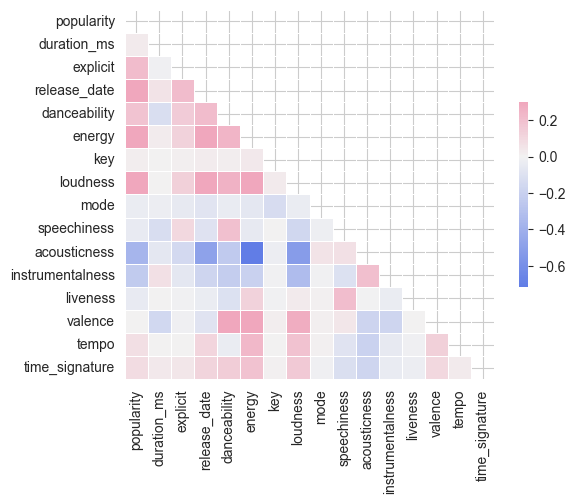

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.995174
Precision: 0.995126
Recall: 0.995067
F1 Score: 0.995096
AUPRC: 0.995743


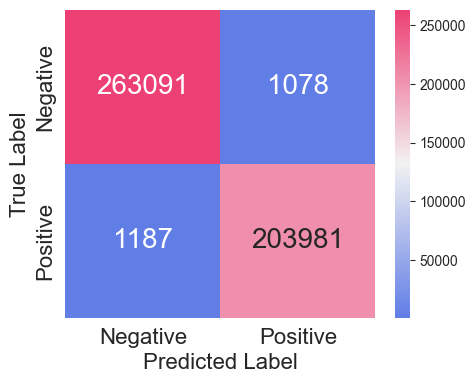


scores for the testing set:
Accuracy: 0.710453
Precision: 0.706324
Recall: 0.700149
F1 Score: 0.701832
AUPRC: 0.736121


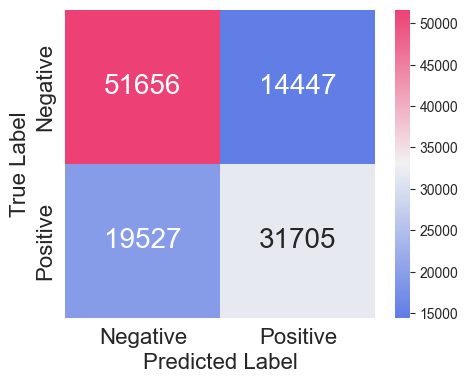

dataset.csv read in successfully as a dataframe


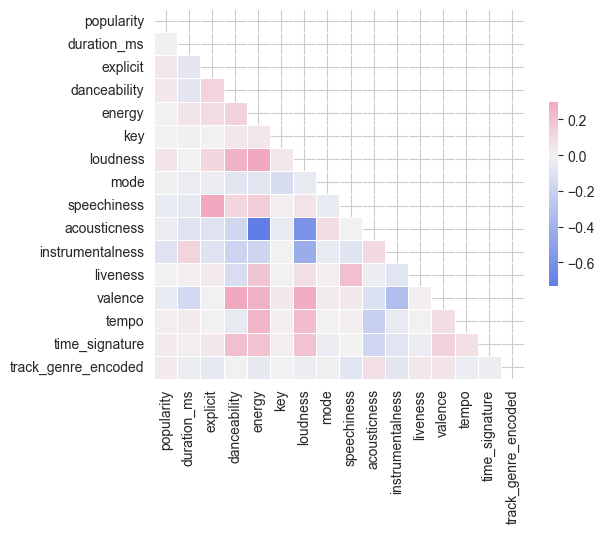

Random Forest Classifier Training...
Random Forest Classifier Fitted

scores for the training set:
Accuracy: 0.994156
Precision: 0.993936
Recall: 0.994286
F1 Score: 0.994107
AUPRC: 0.99659


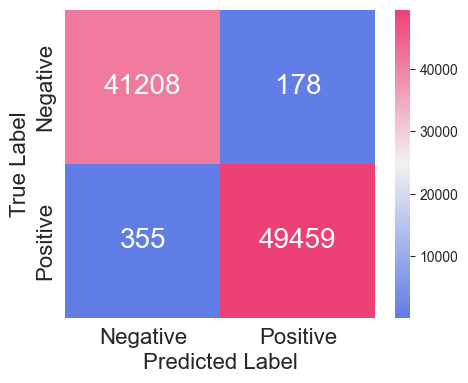


scores for the testing set:
Accuracy: 0.825833
Precision: 0.829435
Recall: 0.819697
F1 Score: 0.822251
AUPRC: 0.879858


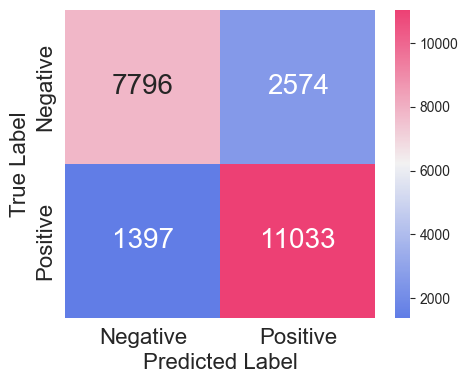


Execution time: 89.16768670082092 seconds


In [8]:
# Putting file specific info into arrays for easier access
files = ['tracks.csv', 'dataset.csv']
inputs = [
    ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
     'valence', 'tempo', 'time_signature', 'explicit'],

    ['track_genre_encoded', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
     'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit']
]
target = ['popularity']

start_time = time.time()

results_df = pd.DataFrame(columns=['algorithm', 'accuracy', 'precision', 'recall', 'f1_score', 'AUPRC'])

for i in range(len(files)):

    df = pd.read_csv('./' + files[i])
    print(files[i], 'read in successfully as a dataframe')
    # File specific cleaning

    # Data cleaning for tracks.csv
    if i == 0:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year
        df = df.drop(columns=['id', 'name', 'artists', 'id_artists'])

    # Data cleaning for dataset.csv
    if i == 1:
        df['track_genre_encoded'] = LabelEncoder().fit_transform(df['track_genre'])
        df = df.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'])

    print_correlation_matrix(df)

    xtrain, xtest, ytrain, ytest = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)

    # # Training Model 1 KNN-Regressor
    # kernelNumber = find_best_kernel_value(False, xtrain, ytrain, xtest, ytest)
    # 
    # print('KNN-Regressor Training...')
    # modelOne = neighbors.KNeighborsRegressor(kernelNumber)
    # modelOne.fit(xtrain, ytrain)
    # print('KNN-Regressor Fitted')
    # 
    # # Apply a same threshold to train predictions
    # y_train, y_train_pred = predict_and_convert(modelOne, xtrain, ytrain, MINIMUM_POPULARITY_LIMIT)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train, y_train_pred, files[i] + ' KNN-Regressor Training')
    # 
    # y_test, y_test_pred = predict_and_convert(modelOne, xtest, ytest, MINIMUM_POPULARITY_LIMIT)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test, y_test_pred, files[i] + ' KNN-Regressor Testing')
    # 
    # # Training Model 2 KNN-Classifier
    # y_train_two = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    # y_test_two = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)
    # 
    # kernelNumber = find_best_kernel_value(True, xtrain, y_train_two, xtest, y_test_two)
    # 
    # print('KNN-Classifier Training...')
    # modelTwo = neighbors.KNeighborsClassifier(kernelNumber)
    # modelTwo.fit(xtrain, y_train_two.values.ravel())
    # print('KNN-Classifier Fitted')
    # 
    # y_train_pred = modelTwo.predict(xtrain)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train_two, y_train_pred, files[i] + ' KNN-Classifier Training')
    # 
    # # Apply a same threshold to test predictions
    # y_test_pred = modelTwo.predict(xtest)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test_two, y_test_pred, files[i] + ' KNN-Classifier Testing')
    # 
    # # Training Model 3 SVM-rbf
    # # The first dataset is too big to reasonably run with SVM as it generally take O(n^3*d) time for training
    # if i == 1:
    #     # Training Model 3 SVM
    #     print('YIIIIIPPPPPEEEEEEEEE')
    #     y_train = (ytrain > MINIMUM_POPULARITY_LIMIT).astype(int)
    #     y_test = (ytest > MINIMUM_POPULARITY_LIMIT).astype(int)
    # 
    #     sc = StandardScaler()
    #     X_train = sc.fit_transform(xtrain)
    #     X_test = sc.transform(xtest)
    # 
    #     # Training the SVM model on the Training set using a linear kernel
    #     print('SVM-Classifier Training...')
    #     modelThree = SVC(kernel='rbf', random_state=42)
    #     modelThree.fit(X_train, y_train.values.ravel())
    #     print('SVM-Classifier Fitted')
    # 
    #     # Predicting the results
    #     print('\nscores for the training set:')
    #     y_pred = modelThree.predict(X_train)
    #     analyze_algorithm(y_train, y_pred, files[i] + ' SVM Training')
    # 
    #     print('\nscores for the testing set:')
    #     y_pred = modelThree.predict(X_test)
    #     analyze_algorithm(y_test, y_pred, files[i] + ' SVM Testing')
    # 
    # Training Model 4 Convolution Neural Network
    X_train, X_test, y_train, y_test = train_test_split(df[inputs[i]], df[target], test_size=0.2, random_state=42)
    y_train = (y_train > MINIMUM_POPULARITY_LIMIT).astype(int)
    y_test = (y_test > MINIMUM_POPULARITY_LIMIT).astype(int)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    y_train = y_train.astype('float32')
    y_test = y_test.astype('float32')
    # 
    # # Define the neural network structure
    # modelFour = Sequential([
    #     Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    #     Dense(64, activation='relu'),
    #     Dense(64, activation='relu'),
    #     Dense(32, activation='relu'),
    #     Dense(1, activation='sigmoid')
    # ])
    # 
    # # Compile the model
    # modelFour.compile(optimizer='adam',
    #                   loss='binary_crossentropy',
    #                   metrics=[f1_score_nn])
    # 
    # y_train_numpy = y_train.to_numpy().astype('int64')
    # unique_classes, class_counts = np.unique(y_train_numpy, return_counts=True)
    # class_weights_dict = {class_label: len(y_train_numpy) / count for class_label, count in
    #                       zip(unique_classes, class_counts)}
    # 
    # # Define EarlyStopping and ModelCheckpoint callbacks.
    # es = EarlyStopping(monitor='val_f1_score_nn', mode='max', verbose=1, patience=15)
    # mc = ModelCheckpoint('best_model.keras', monitor='val_f1_score_nn', mode='max', verbose=1, save_best_only=True,
    #                      save_format='tf')
    # # callbacks=[es, mc]
    # 
    # log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # # callbacks=[tensorboard_callback, es, mc]
    # # Pass class weights and callbacks into model.fit().
    # modelFour.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), batch_size=100,
    #               class_weight=class_weights_dict, callbacks=[es, mc])
    # 
    # # Load the best model
    # modelFour = keras.models.load_model('best_model.keras')
    # 
    # # Make predictions
    # predictions = modelFour.predict(X_test)
    # plt.hist(predictions, bins=20)
    # plt.xlabel('Predicted probabilities')
    # plt.ylabel('Count')
    # plt.show()
    # 
    # predictions = (modelFour.predict(X_train) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    # print('\nscores for the Training set:')
    # analyze_algorithm(y_train, predictions, files[i] + ' Neural Network Training')
    # 
    # predictions = (modelFour.predict(X_test) > MINIMUM_POPULARITY_PERCENTAGE).astype("int64")
    # print('\nscores for the Testing set:')
    # analyze_algorithm(y_test, predictions, files[i] + ' Neural Network Testing')
    # 
    # # Training Model 5 Decision Tree Classifier
    # modelFive = DecisionTreeClassifier()
    # print('Decision Tree Classifier Training...')
    # modelFive.fit(X_train, y_train.values.ravel())
    # print('Decision Tree Classifier Fitted')
    # 
    # y_train_pred = modelFive.predict(X_train)
    # print('\nscores for the training set:')
    # analyze_algorithm(y_train, y_train_pred, files[i] + ' Decision Tree Classifier Training')
    # 
    # y_test_pred = modelFive.predict(X_test)
    # print('\nscores for the testing set:')
    # analyze_algorithm(y_test, y_test_pred, files[i] + ' Decision Tree Classifier Testing')

    # Training Model 6 Random Forest Classifier
    modelSix = RandomForestClassifier(n_estimators=500, n_jobs=-1)
    print('Random Forest Classifier Training...')
    modelSix.fit(X_train, y_train.values.ravel())
    print('Random Forest Classifier Fitted')

    y_train_pred = modelSix.predict(X_train)
    print('\nscores for the training set:')
    analyze_algorithm(y_train, y_train_pred, files[i] + ' Random Forest Classifier Training')

    y_test_pred = modelSix.predict(X_test)
    print('\nscores for the testing set:')
    analyze_algorithm(y_test, y_test_pred, files[i] + ' Random Forest Classifier Testing')

# End timing and print the result
end_time = time.time()

print("\nExecution time: {} seconds".format(end_time - start_time))

results_df.to_csv('resultsof'+str(MINIMUM_POPULARITY_LIMIT)+'.csv', index=False)


In [ ]:
100
Accuracy: 0.82443
Precision: 0.827123
Recall: 0.818762
F1 Score: 0.821086
AUPRC: 0.879257

1000

In [35]:
# %tensorboard --logdir logs/fit